### writes 'coords'  for hillslope boundary case
-  regular grid, no wall
-  elevation from DEM file
- .5m x .5m grid

file format:  
 -  npt, ne  (number of points, number of edges)
 -  for i in npt:  x(i), y(i), z(i)   
 -  loop over cells (j,k):  
     write node numbers surrounding cell, counterclockwise from lower left

In [516]:
%matplotlib inline

In [517]:
import matplotlib.pylab as plt
import numpy as np
import scipy as sp

from osgeo import gdal
import osr


In [523]:
# interpolate DEM to veg 
from scipy import interpolate
# from scipy.interpolate import griddata

# get DEM coords
ds = gdal.Open("/Users/octavia/deesse/dem files/HillslopeDEM.tif")
dem = np.array(ds.GetRasterBand(1).ReadAsArray())
dem[dem < -1e5] = np.nan

nrows, ncols = dem.shape
y0, dy , dydx, x0, dxdy, dx= ds.GetGeoTransform()
x = np.arange(0,  -dx*nrows, -dx)
y  = np.arange(0, dy*ncols, dy )

(95, 64)


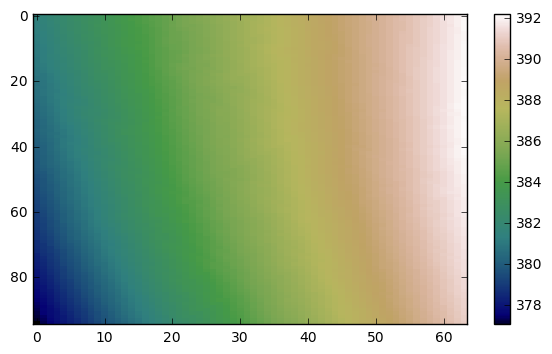

In [524]:
ncol = 94
dx = ncol+1

nrow = 63
dy = nrow+1

xi = 545; xf = xi + dx
yi = 400; yf = yi + dy

# print SLOPE[yi:yf,xi:xf].mean(), '+/-', SLOPE[yi:yf,xi:xf].var() 
plt.figure(figsize = (7, 4))
plt.imshow(dem[xi:xf, yi:yf], cmap='gist_earth', interpolation = 'none',
           aspect = 'auto')
plt.colorbar()
print dem[xi:xf, yi:yf].shape

In [525]:
xdum = x[xi:xf]
ydum = y[yi:yf]
ydum, xdum = np.meshgrid(ydum, xdum)
zdum = dem[ xi:xf,yi:yf]/100.

In [526]:
ncol = len(x[xi:xf])-1
nrow = len(y[yi:yf])-1

In [529]:
npt = (ncol+1)*(nrow+1)
ne = nrow*ncol

In [530]:
x = np.zeros(npt + 1)
y = np.zeros(npt + 1)
z = np.zeros(npt + 1)
x[1:] = xdum.ravel()
y[1:] = ydum.ravel()
z[1:] = zdum.ravel()

In [531]:
# N = sp.randn(nrow+1)/10.
# from  scipy.ndimage.filters import gaussian_filter
# gz =  gaussian_filter(N, 5, order=1, output=None, cval=0.0, truncate=20.0)
# gz = gz + np.linspace(0, 0.3, nrow+1)

In [532]:
nodes = np.arange(1, npt+1, dtype = int).reshape([ ncol+1,nrow+1])

In [534]:
nop = np.zeros([ ncol+1, nrow+1, 4], dtype = int)
for j in range(ncol):
    for k in range(nrow):
        nop[j+1, k+1] =  nodes[j,k], nodes[j+1, k], nodes[j+1,k+1], nodes[j,k+1]

In [535]:
# dry_py.f needs an input file.  this file creates it.
f = open('coords', 'w')
f.write('{0:<13}   {1:<13}\n'.format(npt, ne))

# write x, y, z
for n in range(1, npt+1):
    f.write('{0:<13.6f} {1:<13.6f} {2:<13.6f}\n'.format(x[n],y[n],z[n])) 
    
# write node numbers  
for j in range(1, ncol+1):
    for k in range(1, nrow+1):
        n1 = nop[j, k, 0] 
        n2 = nop[j, k, 1]       
        n3 = nop[j, k, 2]        
        n4 = nop[j, k, 3] 
        f.write('{0:<10} {1:<10}  {2:<10} {3:<10}\n'.format(n1, n2, n3, n4)) 
f.close()

In [538]:
## get cell center values:
xcc  = np.zeros([ncol+2, nrow+2])    
ycc  = np.zeros([ncol+2, nrow+2])
zcc  = np.zeros([ncol+2, nrow+2])

for j in range(ncol+1):
    for k in range( nrow+1):
        n1 = nop[j, k, 0] 
        n2 = nop[j, k, 1]       
        n3 = nop[j, k, 2]        
        n4 = nop[j, k, 3]  
        xcc[j,k] = 0.25*(x[n1] + x[n2] + x[n3] + x[n4])  
        ycc[j,k] = 0.25*(y[n1] + y[n2] + y[n3] + y[n4])
        zcc[j,k] = 0.25*(z[n1] + z[n2] + z[n3] + z[n4])        

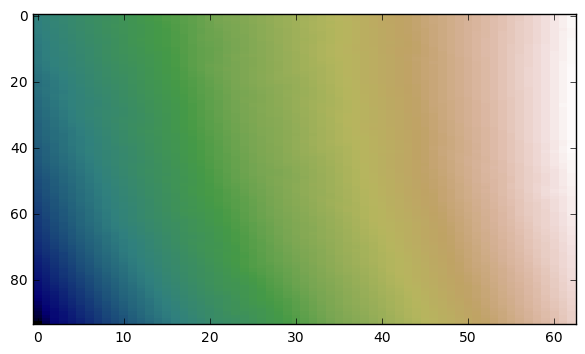

In [541]:
plt.figure(figsize = (7, 4))
plt.imshow(zcc[1:-1, 1:-1], cmap='gist_earth', interpolation = 'none',
           aspect = 'auto')